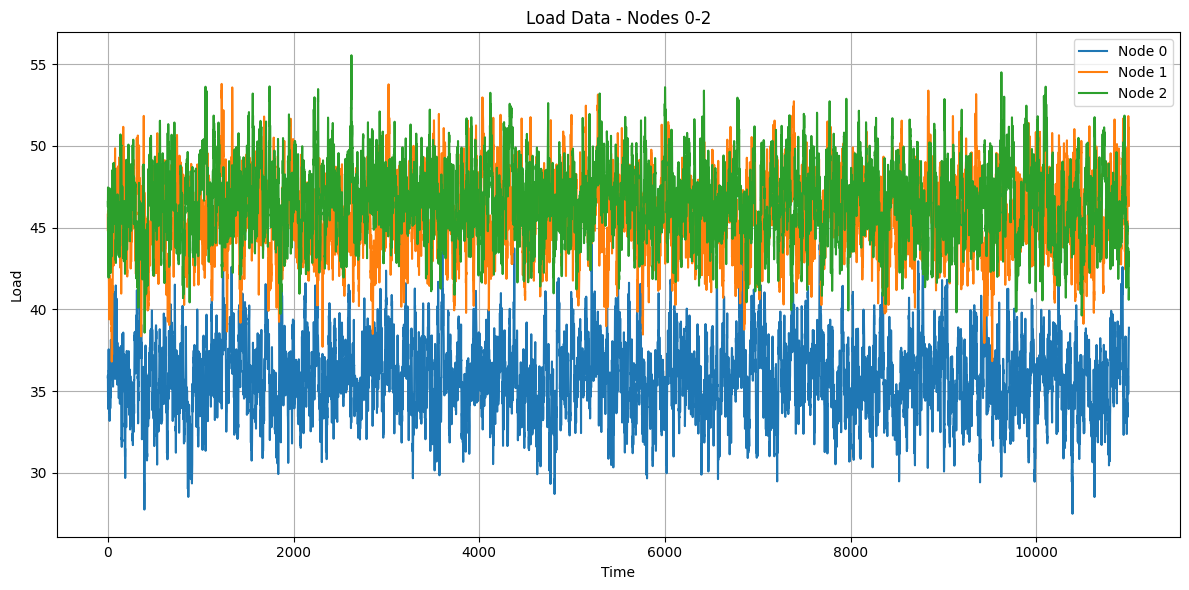

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 绘制指定范围内的数据
def plot_range_data(load_data, start, end, title='Load Data'):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title(f'{title} - Nodes {0}-{N - 1}')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


data = pd.read_csv('load_ar1_data.csv').to_numpy()

plot_range_data(data[:3], start=0, end=len(data[0]), title='Load Data')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [6]:
N = 10
T_train_val = 10000
T_test = 1000
T = T_train + T_test

# 将数据转换为张量
train_val_data = torch.tensor(data[:, :T_train_val], dtype=torch.float32)
test_data = torch.tensor(data[:, T_train_val:], dtype=torch.float32)

In [7]:

# 超参数定义
batch_size = 64  # 批量大小
seq_length = 20  # 序列长度
input_size = 10  # 输入的节点数量
hidden_size = 50  # 隐藏层节点数
output_size = 10  # 输出的节点数量，和输入相同
num_layers = 4  # LSTM层数
learning_rate = 0.001  # 学习率

In [ ]:
# 切分时间序列为多个样本
def create_sequences(train_val_data, seq_length, T_train_val):
    train_set = []
    val_set =  []
    for i in range(T_train_val - seq_length):
        # 循环次数不是T_train - seq_length + 1，因为训练集里并没有第10001个真实数据作为target。
        # 最后一次生成的序列会在逐步更新的过程中使用，而不是在初始训练集中。
        seq = train_val_data[:, i : i + seq_length].T  # 提取每个时间步的序列
        target = train_val_data[:, i + seq_length]  # 提取目标值
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# 生成训练集
train_set, val_set = create_sequences(train_val_data, seq_length, T_train)
train_set = torch.tensor(train_set, dtype=torch.float32)
val_set = torch.tensor(val_set, dtype=torch.float32)

print(f'sequences shape: {train_set.shape}')
print(f'targets shape: {val_set.shape}')

In [ ]:
# 创建数据加载器
train_val_dataset = TensorDataset(train_set, val_set)
dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

print(f'Number of batches: {len(dataloader)}')
print(f'size of input x: {train_set.shape}')

In [ ]:
for i, batch in enumerate(dataloader):
    inputs, val_set = batch
    print(f'{i:>3}: inputs.shape: {inputs.shape}, targets.shape: {val_set.shape}')   
    

In [ ]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态为零
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# 模型初始化
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# 设置学习率调度器：当验证集损失在5个epoch内没有改善时，将学习率降低到原来的0.5倍
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:
%%time
num_epochs = 100  # 训练的轮次

for epoch in tqdm(range(num_epochs), desc='Training LSTM'):
    model.train()
    for inputs, val_set in dataloader:

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, val_set)
    
        # 反向传播和优化
        optimizer.zero_grad()  # 清除之前的梯度
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新参数
    
    # 清理缓存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # 每10轮输出一次损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# model.eval()  # 切换到评估模式
total_loss = 0

# 保存预测值和真实值
predictions = []
true_values = []

# 初始化测试输入，使用训练集的最后一个序列
x_test = train_val_data[:, -seq_length:].T.unsqueeze(0)  # 形状为 [1, 20, 10]
print(f'Initial input shape: {x_test.shape}')

for i in range(T_test):
    # 模型保持在训练模式，以便进行微调
    model.train()
    
    # 预测当前时间步的值
    # with torch.no_grad():
    pred = model(x_test)  # 形状为 [1, 10]
    
    # 获取当前真实值
    real_value = test_data[:, i]  # 形状为 [10]
    
    # 保存预测值和真实值
    # predictions.append(pred.squeeze(0).cpu().numpy())  # 从GPU转移到CPU, 
    # true_values.append(real_value.cpu().numpy())  # 从GPU转移到CPU，然后转换为numpy数组

    predictions.append(pred.squeeze(0).detach().cpu().numpy())  # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
    true_values.append(real_value.detach().cpu().numpy())  # 同上
    
    # 计算当前时间步的误差
    loss = criterion(pred.squeeze(0), real_value)
    total_loss += loss.item()
    print(f'Step [{i+1}/{T_test}], Loss: {loss.item():.4f}')
    
    # 使用真实值更新模型（微调）
    # model.train()  # 切换回训练模式
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 为下一个时间步准备输入：将真实值添加到输入序列的末尾
    x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

# 计算平均损失
avg_loss = total_loss / T_test
print(f'Average Loss over 1000 steps: {avg_loss:.4f}')

# 转换预测值和真实值为 NumPy 数组
predictions = np.array(predictions)
true_values = np.array(true_values)

In [ ]:
# 输出图像
plt.figure(figsize=(12, 6))

# 假设你想绘制第一个节点的预测结果
plt.plot(predictions[:, 0], label='Predicted')
plt.plot(true_values[:, 0], label='True')
plt.xlabel('Time Steps')
plt.ylabel('Load Value')
plt.title('Predicted vs True Load Values for Node 1')
plt.legend()

# 显示图像
plt.show()